In [1]:
import numpy as np
from qiskit import Aer
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.opflow import X, Y, Z, I, StateFn, PauliExpectation, CircuitSampler, Gradient
from qiskit.utils import QuantumInstance
from qiskit.circuit import ParameterVector

In [2]:
# BACKEND
quantum_instance = QuantumInstance(Aer.get_backend('qasm_simulator'),
                                   # we'll set a seed for reproducibility
                                   shots = 8192, seed_simulator = 2718,
                                   seed_transpiler = 2718)
sampler = CircuitSampler(quantum_instance)

In [3]:
# HAMILTONIAN
hamiltonian = (-0.24274280046556912) * (I ^ I ^ Z ^ I)\
+ (-0.24274280046556912) * (I^I^I^Z) \
+ (-0.04207898539392574) * (I^I^I^I) \
+ (0.17771287502700941) * (Z^I^I^I) \
+ (0.17771287502700941) * (I^Z^I^I)\
+ (0.12293305045306256) * (Z^I^Z^I) \
+ (0.12293305045306256) * (I^Z^I^Z) \
+ (0.1676831943187453) * (Z^I^I^Z) \
+ (0.1676831943187453) * (I^Z^Z^I) \
+ (0.17059738365072868) * (Z^Z^I^I) \
+ (0.17627640722384352) * (I^I^Z^Z) \
+ (-0.04475014386568271) * (Y^Y^X^X) \
+ (-0.04475014386568271) * (X^X^Y^Y) \
+ (0.04475014386568271) * (Y^X^X^Y) \
+ (0.04475014386568271) * (X^Y^Y^X)

In [4]:
# INITIAL POINT
np.random.seed(0)
init_params = np.random.uniform(low=0, high=2 * np.pi, size=12)

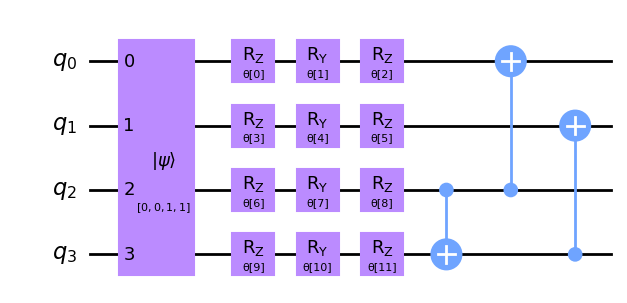

In [8]:
# ANSATZ
nparams = 12
nqubits = 4
qreg_q = QuantumRegister(nqubits, 'q')
circuit = QuantumCircuit(qreg_q)
params = ParameterVector('θ', nparams)
circuit.initialize('0011')
for i in range(nqubits):
    circuit.rz(params[3 * i], qreg_q[i])
    circuit.ry(params[3 * i + 1], qreg_q[i])
    circuit.rz(params[3 * i + 2], qreg_q[i])
circuit.cx(qreg_q[2], qreg_q[3])
circuit.cx(qreg_q[2], qreg_q[0])
circuit.cx(qreg_q[3], qreg_q[1])
circuit.draw('mpl')

In [6]:
# COST
expectation = StateFn(hamiltonian, is_measurement=True) @ StateFn(ansatz)
pauli_basis = PauliExpectation().convert(expectation)
def cost(params):
    value_dict = dict(zip(ansatz.parameters, params))
    result = sampler.convert(pauli_basis, params=value_dict).eval()
    return np.real(result)
cost([3.44829694e+00, 6.28318531e+00, 3.78727399e+00, 3.42360201e+00,
 5.09234599e-08, 4.05827240e+00, 2.74944154e+00, 6.07360302e+00,
 6.24620659e+00, 2.40923412e+00, 6.28318531e+00, 3.32314479e+00])

0.5149599263488516

In [10]:
gradient = Gradient().convert(expectation)
gradient_in_pauli_basis = PauliExpectation().convert(gradient)

def evaluate_gradient(theta):
    value_dict = dict(zip(ansatz.parameters, theta))
    result = sampler.convert(gradient_in_pauli_basis,
                             params=value_dict).eval()
    return np.real(result)

In [11]:
class OptimizerLog:
    """Log to store optimizer's intermediate results"""
    def __init__(self):
        self.loss = []
    def update(self, _nfevs, _theta, ftheta, *_):
        """Save intermediate results. Optimizers pass many values
        but we only store the third ."""
        self.loss.append(ftheta)

from qiskit.algorithms.optimizers import GradientDescent
gd_log = OptimizerLog()
gd = GradientDescent(maxiter=300,
                     learning_rate=0.5,
                     tol=1e-6,
                     callback=gd_log.update)

In [12]:
result = gd.minimize(
    fun=cost,  # function to minimize
    x0=init_params,          # initial point
    jac=evaluate_gradient      # function to evaluate gradient
)

import matplotlib.pyplot as plt
plt.figure(figsize=(7, 3))
plt.plot(gd_log.loss, label='vanilla gradient descent')
plt.axhline(-1, ls='--', c='C3', label='target')
plt.ylabel('loss')
plt.xlabel('iterations')
plt.legend();

KeyboardInterrupt: 